
# Time Syncronization of DESI Telemetry Data

As is, the DESI telemetry data is spread out across multiple different tables. As is is shown in the correlations plots in the `correlation` folder, there us very weak correlation across different tables. Before proper analysis can be done, the several datatables of interest must 
be syncronized in time. This involves rebinning and interpolation of the data is currently being hosted by NERSC.

## On going tasks

- ~~how to characterize telescope's response in relation to~~
- how can we predict temperature for following night
- ~~include delta temperature and mirror cooling in additional plots~~
- reponse time when cooling turns on, and cooling turns off
- mirror temp lower than is better than air being lower
- minimize delta-T
- ~~calculation variation of air temperatue throughout the day (standard deviation)~~
- ~~resample data using df.resample~~
- ~~plot delta as a function of time, find windows where delta is lower than plus or minus 1.5~~
- find a good window for a "day" because cooling with overlap noon-to-noon window (8pm-to-8am window?)
- mirror cooling isn't adjusted by operators unless requested to do so

## Imports

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import pickle
import matplotlib.pyplot as plt
from IPython.display import display, Image
import pytz
data_dir = '../../py/desiforecast/data'
try:
    from numba import cuda
    cuda.detect()
    %pip install -q cudf-cu11 dask-cudf-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
    import cupy as cp
    import cudf
    gpu_access = True
except:
    gpu_access = False
    print('No GPU devices available!')

## Load Data

In [124]:
def preprocess(df):
    df.set_index('time_recorded', inplace=True)
    df = df.resample('6S').mean().tz_convert("America/Phoenix")
    if 'seeing' in df.columns.values:
        df.dropna(inplace=True)
    else:
        df.interpolate(limit_direction='both', inplace=True)
    return df

In [ ]:
if gpu_access:
    with open(f'{data_dir}/environmentmonitor_tower.pkl', 'rb') as pf:
        tower_data = pickle.load(pf)
    with open(f'{data_dir}/environmentmonitor_dome.pkl', 'rb') as pf:
        dome_data = pickle.load(pf)
    with open(f'{data_dir}/environmentmonitor_telescope.pkl', 'rb') as pf:
        telescope_data = pickle.load(pf)
    with open(f'{data_dir}/etc_seeing.pkl', 'rb') as pf:
        seeing_data = pickle.load(pf)
    with open(f'{data_dir}/etc_telemetry.pkl', 'rb') as pf:
        telemetry_data = pickle.load(pf)
    with open(f'{data_dir}/tcs_info.pkl', 'rb') as pf:
        tcs_data = pickle.load(pf)

In [125]:
with open(f'{data_dir}/unsampled/unsampled_environmentmonitor_tower.pkl', 'rb') as pf:
    tower_data = preprocess(pickle.load(pf))
with open(f'{data_dir}/unsampled/unsampled_environmentmonitor_dome.pkl', 'rb') as pf:
    dome_data = preprocess(pickle.load(pf))
with open(f'{data_dir}/unsampled/unsampled_environmentmonitor_telescope.pkl', 'rb') as pf:
    telescope_data = preprocess(pickle.load(pf))
with open(f'{data_dir}/unsampled/unsampled_etc_seeing.pkl', 'rb') as pf:
    seeing_data = preprocess(pickle.load(pf))
with open(f'{data_dir}/unsampled/unsampled_etc_telemetry.pkl', 'rb') as pf:
    telemetry_data = preprocess(pickle.load(pf))
with open(f'{data_dir}/unsampled/unsampled_tcs_info.pkl', 'rb') as pf:
    tcs_data = preprocess(pickle.load(pf))

In [ ]:
if gpu_access:
    tower_data = cudf.from_pandas(tower_data)
    dome_data = cudf.from_pandas(dome_data)
    telescope_data = cudf.from_pandas(telescope_data)
    seeing_data = cudf.from_pandas(seeing_data)
    telemetry_data = cudf.from_pandas(telemetry_data)
    tcs_data = cudf.from_pandas(tcs_data)

In [ ]:
print(type(tower_data.index))
print(type(dome_data.index))
print(type(telescope_data.index))
print(type(telemetry_data.index))
print(type(seeing_data.index))
print(type(tcs_data.index))

In [ ]:
print(tower_data)
print(dome_data)
print(telescope_data)
print(telemetry_data)
print(seeing_data)
print(tcs_data)

In [116]:
# verify that there are no null values in data tables
print(tower_data.notnull().values.all())
print(dome_data.notnull().values.all())
print(telescope_data.notnull().values.all())
print(telemetry_data.notnull().values.all())
print(seeing_data.notnull().values.all())
print(tcs_data.notnull().values.all())

True
True
True
True
True
True


In [ ]:
with open('../data/resampled_tower_data.pkl', 'wb') as pf:
    pickle.dump(tower_data, pf)
with open('../data/resampled_dome_data.pkl', 'wb') as pf:
    pickle.dump(dome_data, pf)
with open('../data/resampled_telescope_data.pkl', 'wb') as pf:
    pickle.dump(telescope_data, pf)
with open('../data/resampled_seeing_data.pkl', 'wb') as pf:
    pickle.dump(seeing_data, pf)
with open('../data/resampled_telemetry_data.pkl', 'wb') as pf:
    pickle.dump(telemetry_data, pf)
with open('../data/resampled_tcs_data.pkl', 'wb') as pf:
    pickle.dump(tcs_data, pf)

In [ ]:
temp_delta = (telescope_data['air_temp']-telescope_data['mirror_temp']).dropna()
print(f'mininum: {temp_delta.min()}')
print(f'maximum: {temp_delta.max()}')
print(f'variance: {temp_delta.var()}')
print(f'standard deviation: {temp_delta.std()}')

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(temp_delta.index, temp_delta, label='temperature delta')
ax.set_title('Temperature Delta (Celcius) vs. Date & Time')
ax.set_ylabel('Temperature Delta (Celcius)')
ax.set_xlabel('Date & Time')
fig.autofmt_xdate()
plt.legend()
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig('temp_delta.png', format='png')
plt.show()

In [117]:
# removes results outside of 5 std
def remove_outliers(df):
    if df.isnull().values.any():
        df.dropna(inplace=True)
    return df[(np.abs(stats.zscore(df.to_numpy())) < 5)]

In [ ]:
temp_delta = remove_outliers(telescope_data['air_temp']-telescope_data['mirror_temp'])
print(f'mininum: {temp_delta.min()}')
print(f'maximum: {temp_delta.max()}')
print(f'variance: {temp_delta.var()}')
print(f'standard deviation: {temp_delta.std()}')

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(temp_delta.index, temp_delta, label='temperature delta')
ax.set_title('Temperature Delta (Celcius) vs. Date & Time')
ax.set_ylabel('Temperature Delta (Celcius)')
ax.set_xlabel('Date & Time')
fig.autofmt_xdate()
plt.legend()
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig('temp_delta_no_outliers.png', format='png')
plt.show()

In [ ]:
print(type(time))
print(time)
print(type(temp_delta))
print(temp_delta)

In [ ]:
print(telescope_data.columns.values)

In [ ]:
new = sort_and_resample(tower_data)
print(len(new))
print(f'start: {new.index[0]}')
print(f'end: {new.index[-1]}')
print(len(tower_data))
print(len(new)-len(tower_data))

In [ ]:
new = sort_and_resample(etc_seeing_data)
print(len(new))
print(f'start: {new.index[0]}')
print(f'end: {new.index[-1]}')
print(len(etc_seeing_data))
print(len(new)-len(etc_seeing_data))

In [ ]:
new = sort_and_resample(etc_telemetry_data)
print(len(new))
print(f'start: {new.index[0]}')
print(f'end: {new.index[-1]}')
print(len(etc_telemetry_data))
print(len(new)-len(etc_telemetry_data))

In [ ]:
new2 = cudf.from_pandas(new)

In [ ]:
new = sort_and_resample(tcs_info_data)
print(len(new))
print(f'start: {new.index[0]}')
print(f'end: {new.index[-1]}')
print(len(tcs_info_data))
print(len(new)-len(tcs_info_data))

## GPU Compute Testing

## Data Visualization Before Syncrization

In [ ]:
start_date = cudf.Timestamp(year=2019,month=10,day=15,hour=0,minute=0,second=0,microsecond=0)
end_date = cudf.Timestamp(year=2023,month=1,day=1,hour=0,minute=0,second=0,microsecond=0)
print(start_date)
print(end_date)
print(end_date-start_date)
assert(start_date<end_date)

In [ ]:
# Do the start dates of the tables match?
time = tower_data.index[0]
print(time)
# print(dome_data['time_recorded'][0])
# print(telescope_data['time_recorded'][0])

In [ ]:
print(type(start_date+pd.DateOffset(days=1)))
print(start_date+pd.DateOffset(days=1))

In [ ]:
start_date = pd.Timestamp(year=2022,month=9,day=24,hour=12,minute=0,second=0, tz="America/Phoenix")
end_date = start_date+pd.DateOffset(days=3)
telescope_indicies = cp.argwhere(cp.logical_and(telescope_data.index >= start_date, telescope_data.index <= end_date))
print(type(telescope_indicies))
# print(type(telescope_indicies[0]))
print(telescope_data.iloc[telescope_indicies])

In [ ]:
indicies = cp.argwhere(cp.logical_and(telescope_data.index >= start_date, telescope_data.index <= end_date)).flatten()
print(indicies)

In [ ]:
%timeit np.argwhere(np.logical_and(telescope_data.index >= start_date, telescope_data.index <= end_date)).flatten()

In [ ]:
start_date = pd.Timestamp(year=2022,month=9,day=24,hour=17, minute=0, second=0, microsecond=0, tz="America/Phoenix")-pd.DateOffset(day=1)
start_date = start_date.to_numpy()
print(type(start_date))
print(type(telescope_data.index[0]))

In [118]:
def new_temperature_plot(year=2022, month=9, day=24, offset=1, save=False):
    start_date = pd.Timestamp(year=year,month=month,day=day,hour=17, minute=0, second=0, microsecond=0, tz="America/Phoenix")-pd.DateOffset(day=1)
    end_date = start_date+pd.DateOffset(day=offset)
    if gpu_access:
        start_date = start_date.to_numpy()
        end_date = end_date.to_numpy()

    print(f'Start date: {start_date}')
    print(f'Offset length (# of days): {offset}')
    
    fig, ax = plt.subplots(ncols=2, figsize=(20,10))
    ax0_plots = []
    ax1_plots = []
    ax[0].autoscale(True)
    ax[0].set_title('Mirror Temperature & Seeing vs. Date/Time')
    ax[0].set_ylabel('Mirror Temperature (Celcius)')
    ax[0].set_xlabel('Date/Time')
    ax[1].autoscale(True)
    ax[1].set_title('Dome & Tower Temperature vs. Date/Time')
    ax[1].set_ylabel('Dome Temperature (Celcius)')
    ax[1].set_xlabel('Date/Time')

    telescope_indicies = np.argwhere(np.logical_and(telescope_data.index >= start_date, telescope_data.index <= end_date)).flatten()
    temp_delta = remove_outliers(telescope_data.iloc[telescope_indicies]['air_temp']-telescope_data.iloc[telescope_indicies]['mirror_temp'])
    print(f'Number of valid telescope environment samples in current time window: {len(telescope_indicies)}')
    if len(telescope_indicies):
        ax0_plots.append(ax[0].plot(telescope_data.index[telescope_indicies], telescope_data.iloc[telescope_indicies]['mirror_avg_temp'], label='average mirror temp')[0])
        ax0_plots.append(ax[0].plot(telescope_data.index[telescope_indicies], telescope_data.iloc[telescope_indicies]['mirror_temp'], label='mirror temp')[0])
        ax0_plots.append(ax[0].plot(telescope_data.index[telescope_indicies], telescope_data.iloc[telescope_indicies]['mirror_desired_temp'], label='desired mirror temp')[0])
        ax0_plots.append(ax[0].plot(telescope_data.index[telescope_indicies], telescope_data.iloc[telescope_indicies]['air_temp'], label='air temp')[0])
        ax0_plots.append(ax[0].plot(telescope_data.index[telescope_indicies], telescope_data.iloc[telescope_indicies]['mirror_cooling'], label='mirror cooling')[0])
        ax0_plots.append(ax[0].plot(temp_delta.index, temp_delta, label='temp delta')[0])
        ax[0].axhline(y=1.5, color='maroon', linestyle='--')
        ax[0].axhline(y=-1.5, color='maroon', linestyle='--')
        ax[0].annotate(u"1.5 \u2103", xy=(end_date, 1.75), annotation_clip=False, ha='right')
        ax[0].annotate(u"-1.5 \u2103", xy=(end_date, -1.25), annotation_clip=False, ha='right')

    telemetry_indicies = np.argwhere(np.logical_and(telemetry_data.index >= start_date, telemetry_data.index <= end_date)).flatten()
    print(f'Number of valid etc telemetry samples in current time window: {len(telemetry_indicies)}')
    if len(telemetry_indicies):
        twin0 = ax[0].twinx()
        ax0_plots.append(twin0.plot(telemetry_data.index[telemetry_indicies], telemetry_data.iloc[telemetry_indicies]['seeing'], color="indigo", label='seeing')[0])
        twin0.autoscale(True)
        twin0.set_ylabel('Seeing')
    
#     dome_indicies = cp.argwhere(cp.logical_and(dome_data.index >= start_date, dome_data.index <= end_date)).flatten()
#     print(f'Number of valid dome environment samples in current time window: {len(dome_indicies)}')
#     if len(dome_indicies):
#         ax1_plots.append(ax[1].plot(dome_data.index[dome_indicies], dome_data.iloc[dome_indicies]['dome_floor_ne'], label='dome floor temp (NE)')[0])
#         ax1_plots.append(ax[1].plot(dome_data.index[dome_indicies], dome_data.iloc[dome_indicies]['dome_floor_nw'], label='dome floor temp (NW)')[0])
#         ax1_plots.append(ax[1].plot(dome_data.index[dome_indicies], dome_data.iloc[dome_indicies]['dome_floor_s'], label='dome floor temp (S)')[0])

#     tower_indicies = cp.argwhere(cp.logical_and(tower_data.index >= start_date, tower_data.index <= end_date)).flatten()
#     print(f'Number of valid tower environment samples in current time window: {len(tower_indicies)}')
#     if len(tower_indicies):
#         twin1 = ax[1].twinx()
#         ax1_plots.append(twin1.plot(tower_data.index[tower_indicies], tower_data.iloc[tower_indicies]['temperature'], color="indigo", label='tower temp')[0])
#         twin1.autoscale(True)
#         twin1.set_ylabel('Tower Temperature (Celcius)')
    
    if ax1_plots:
        ax[1].legend(handles=ax1_plots)
    else:
        ax[1].remove()

    if ax0_plots:
        ax[0].legend(handles=ax0_plots)
        if save:
            plt.savefig(f'time_plots/with_temp_delta/{year}-{month}-{day}_{offset}-day-offset.png', format='png')
        plt.show()
    else:
        print("Insufficient data in this time window!")

In [ ]:
new_temperature_plot()

Start date: 2022-06-01 17:00:00-07:00
Offset length (# of days): 1
Number of valid telescope environment samples in current time window: 1
Number of valid etc telemetry samples in current time window: 0


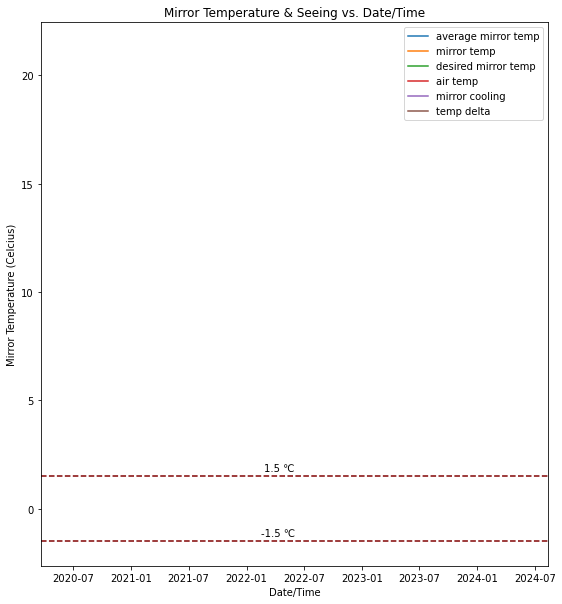

In [171]:
new_temperature_plot(year=2022, month=6, day=10, offset=1, save=True)

Start date: 2022-06-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 9000


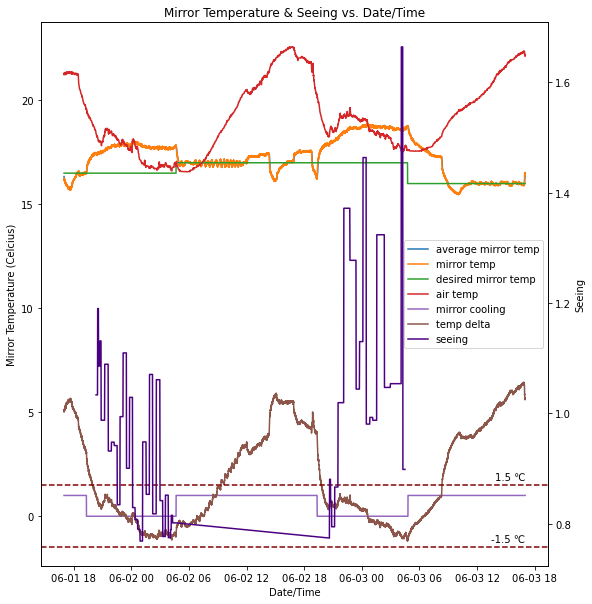

In [128]:
new_temperature_plot(year=2022, month=6, day=10, offset=3, save=True)

Start date: 2022-06-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 9000


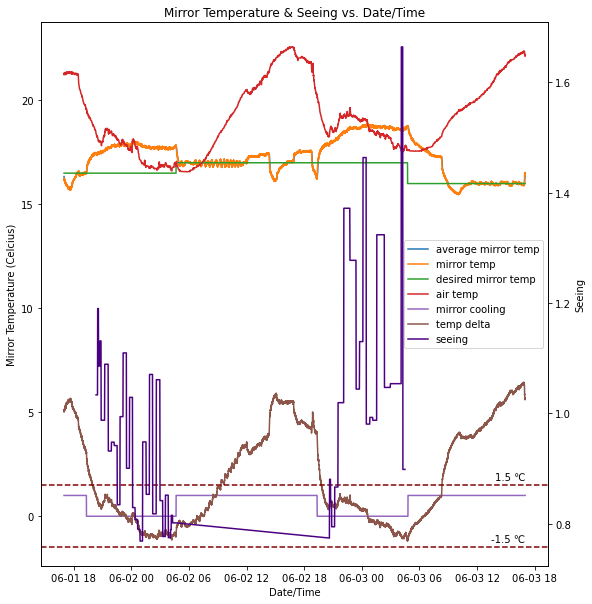

In [129]:
new_temperature_plot(year=2022, month=6, day=10, offset=3, save=True)

Start date: 2022-01-01 17:00:00-07:00
Offset length (# of days): 7
Number of valid telescope environment samples in current time window: 86401
Number of valid etc telemetry samples in current time window: 35802


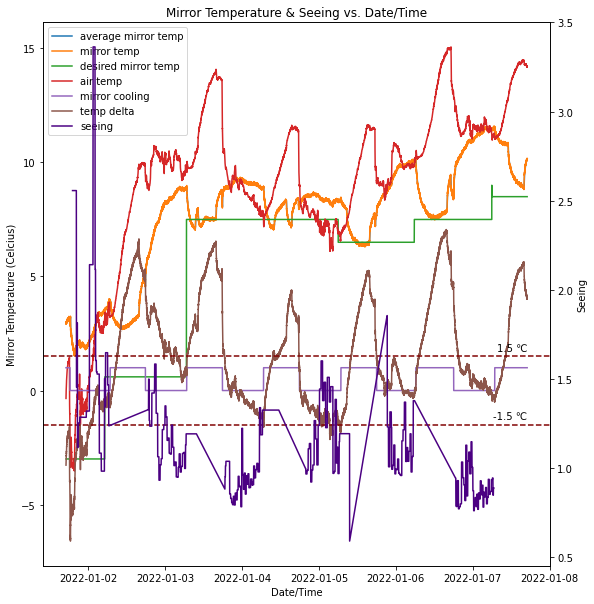

In [130]:
new_temperature_plot(year=2022, month=1, day=1, offset=7, save=True)

Start date: 2021-12-01 17:00:00-07:00
Offset length (# of days): 7
Number of valid telescope environment samples in current time window: 86401
Number of valid etc telemetry samples in current time window: 33783


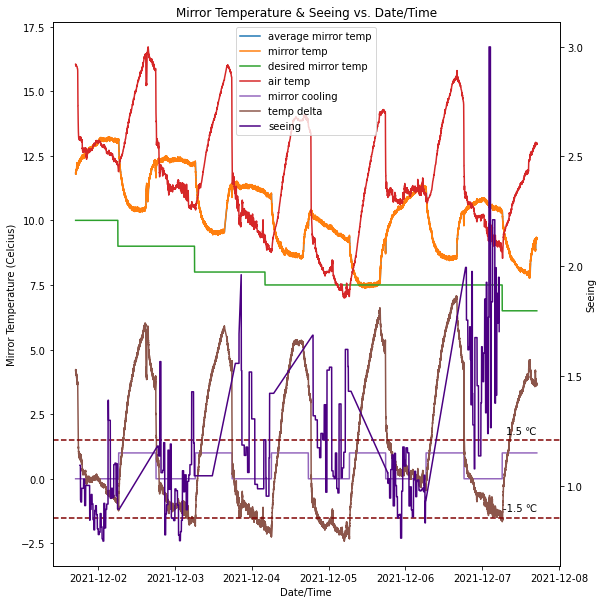

In [131]:
new_temperature_plot(year=2021, month=12, day=27, offset=7, save=True)

Start date: 2022-01-01 17:00:00-07:00
Offset length (# of days): 7
Number of valid telescope environment samples in current time window: 86401
Number of valid etc telemetry samples in current time window: 35802


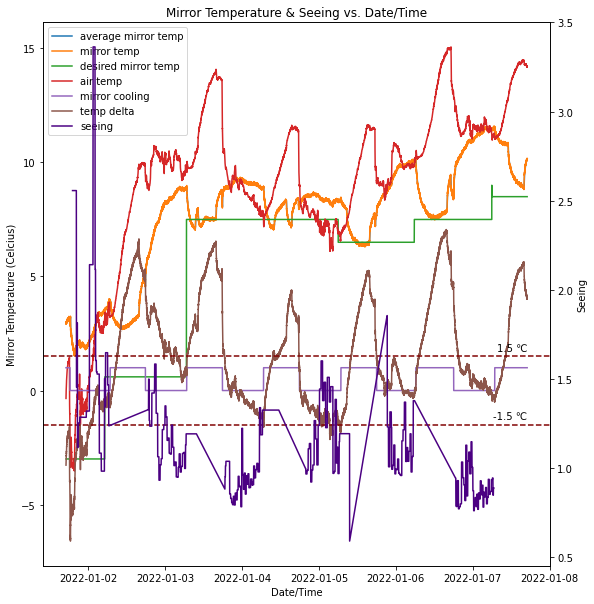

In [132]:
new_temperature_plot(year=2022, month=1, day=21, offset=7, save=True)

Start date: 2021-02-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 0


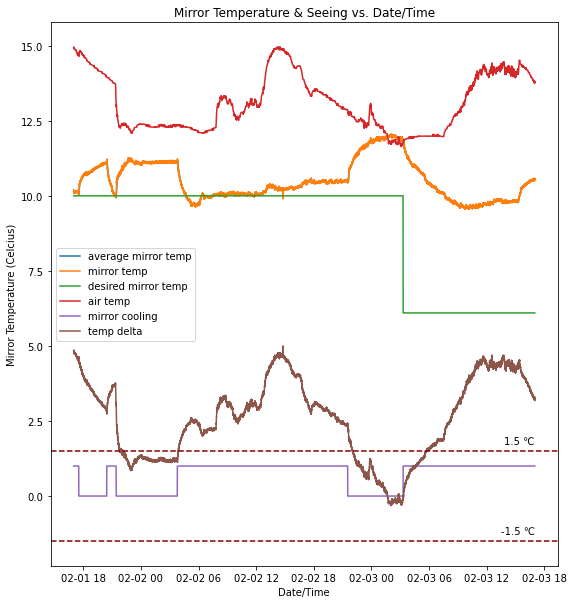

In [133]:
new_temperature_plot(year=2021, month=2, day=1, offset=3, save=True)

Start date: 2021-02-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 0


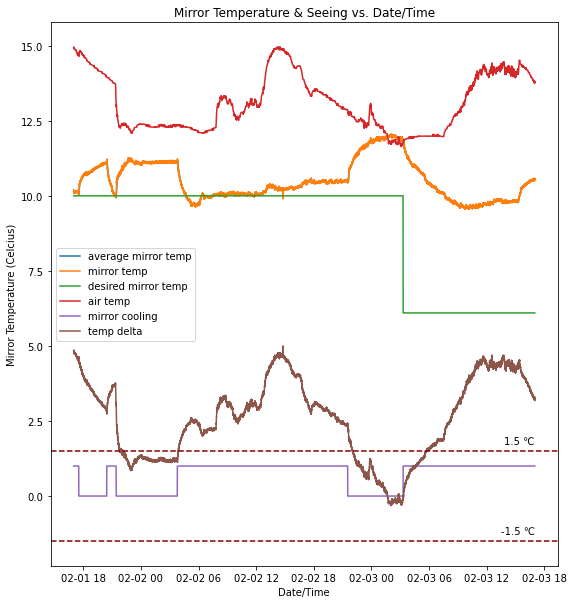

In [134]:
new_temperature_plot(year=2021, month=2, day=15, offset=3, save=True)

Start date: 2021-06-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 6976


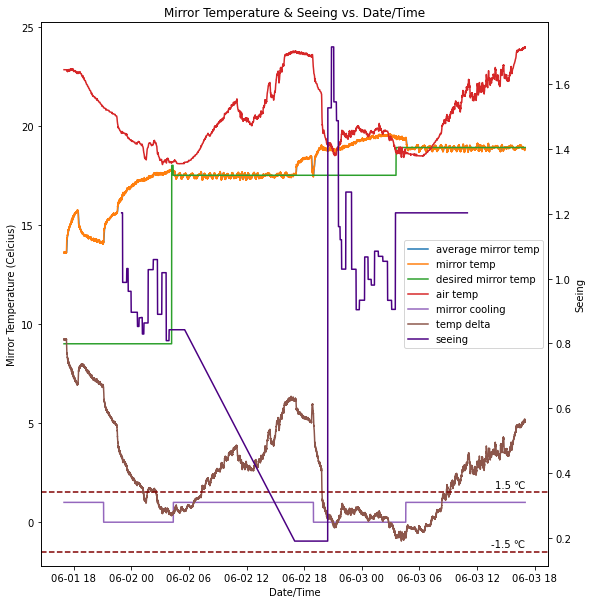

In [135]:
new_temperature_plot(year=2021, month=6, day=15, offset=3, save=True)

Start date: 2021-07-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 0


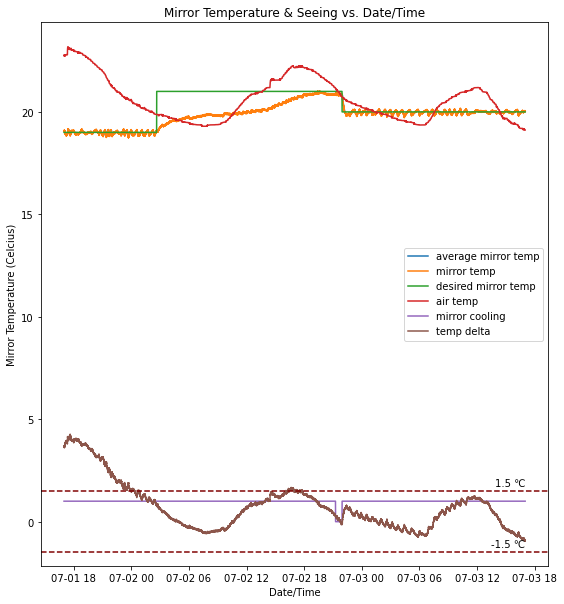

In [136]:
new_temperature_plot(year=2021, month=7, day=15, offset=3, save=True)

Start date: 2021-08-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 0


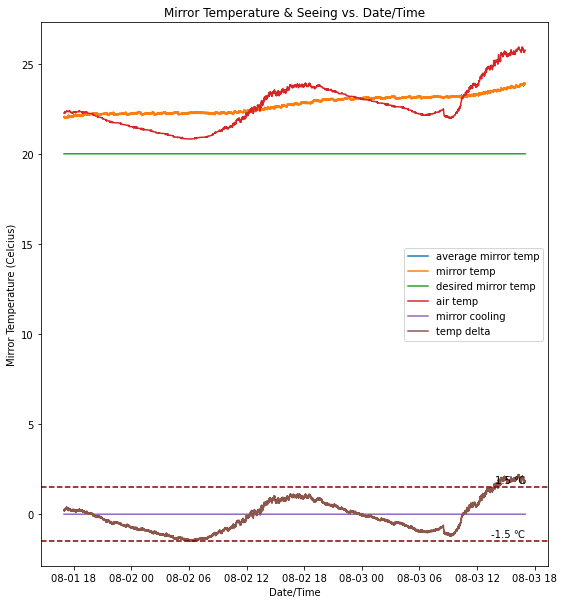

In [137]:
new_temperature_plot(year=2021, month=8, day=15, offset=3, save=True)

Start date: 2021-09-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 0


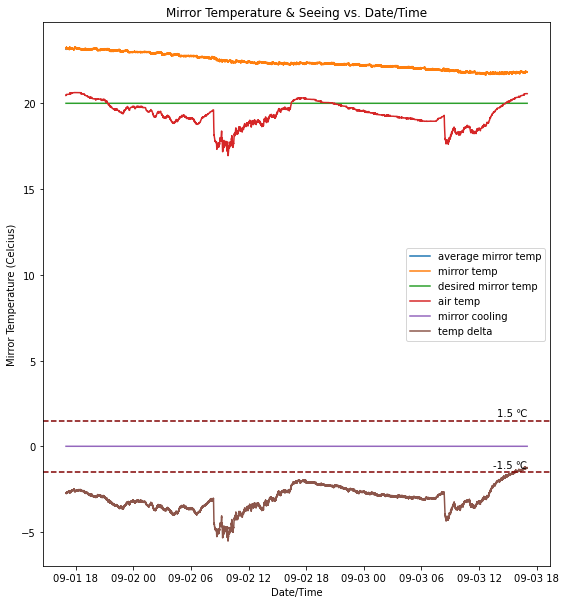

In [138]:
new_temperature_plot(year=2021, month=9, day=15, offset=3, save=True)

Start date: 2021-10-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 11309


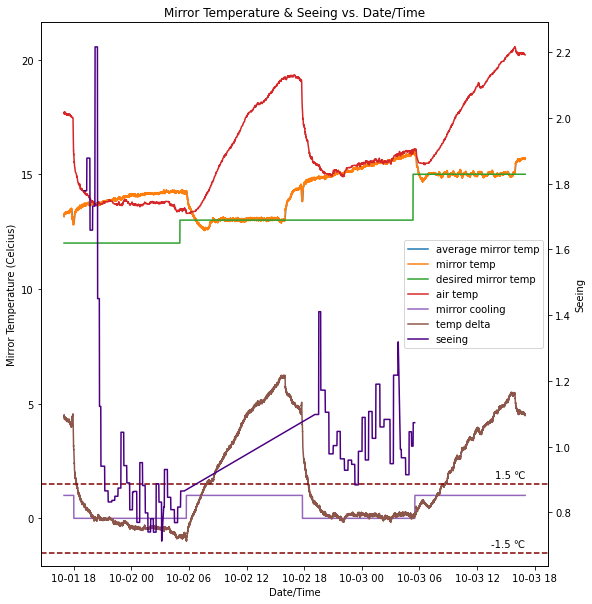

In [139]:
new_temperature_plot(year=2021, month=10, day=15, offset=3, save=True)

Start date: 2021-11-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 12394


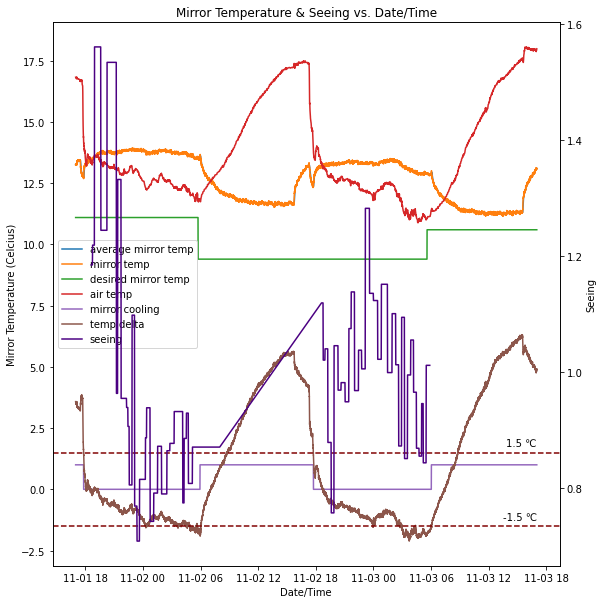

In [140]:
new_temperature_plot(year=2021, month=11, day=15, offset=3, save=True)

Start date: 2021-12-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 12281


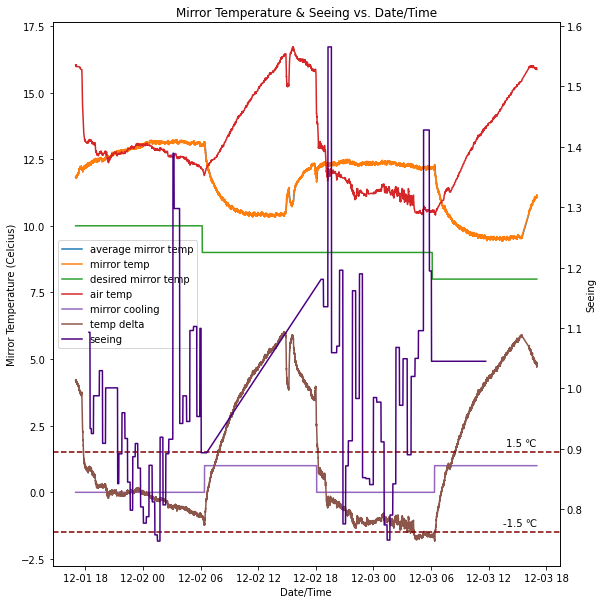

In [141]:
new_temperature_plot(year=2021, month=12, day=15, offset=3, save=True)

Start date: 2021-03-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 7


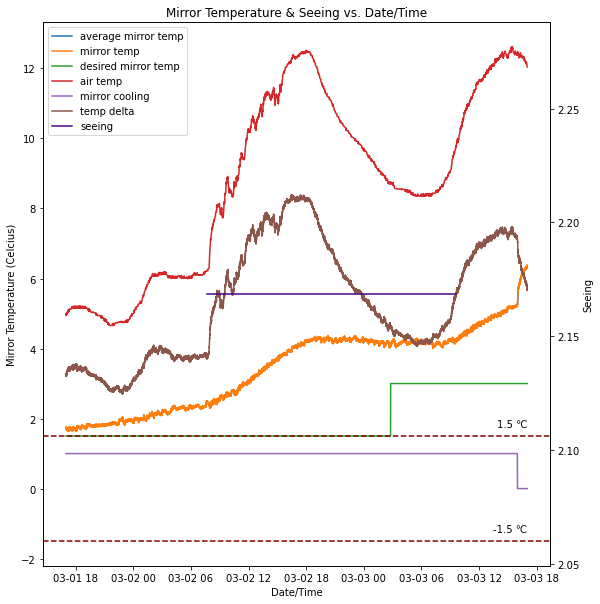

In [142]:
new_temperature_plot(year=2021, month=3, day=15, offset=3, save=True)

Start date: 2021-04-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 5183


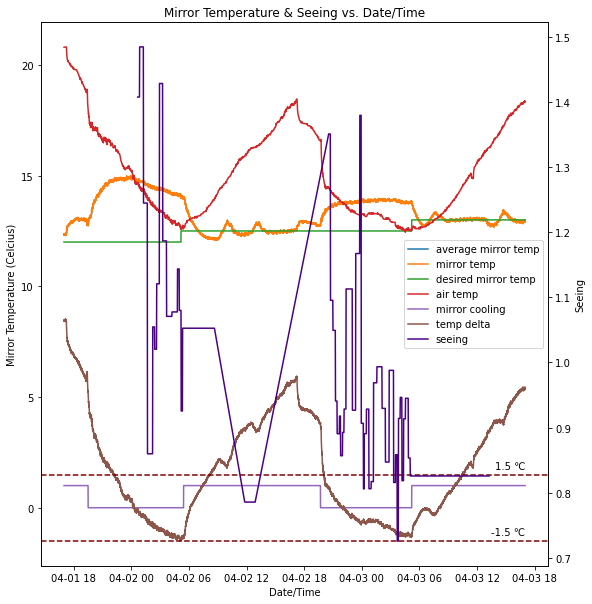

In [143]:
new_temperature_plot(year=2021, month=4, day=15, offset=3, save=True)

Start date: 2021-05-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 4893


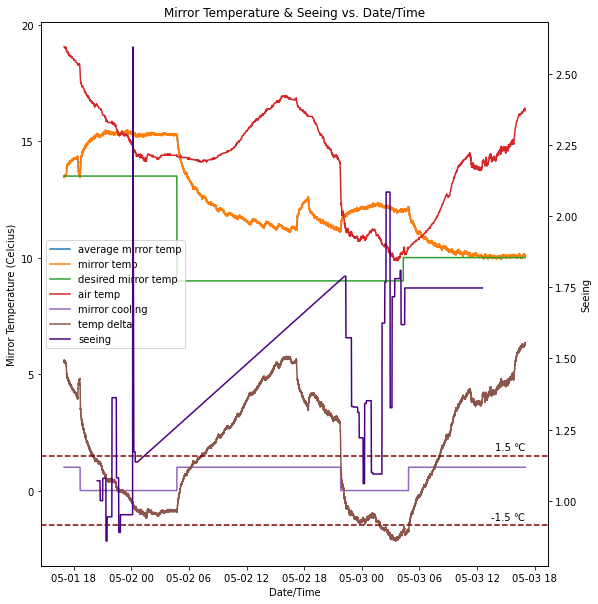

In [144]:
new_temperature_plot(year=2021, month=5, day=15, offset=3, save=True)

Start date: 2022-01-01 17:00:00-07:00
Offset length (# of days): 7
Number of valid telescope environment samples in current time window: 86401
Number of valid etc telemetry samples in current time window: 35802


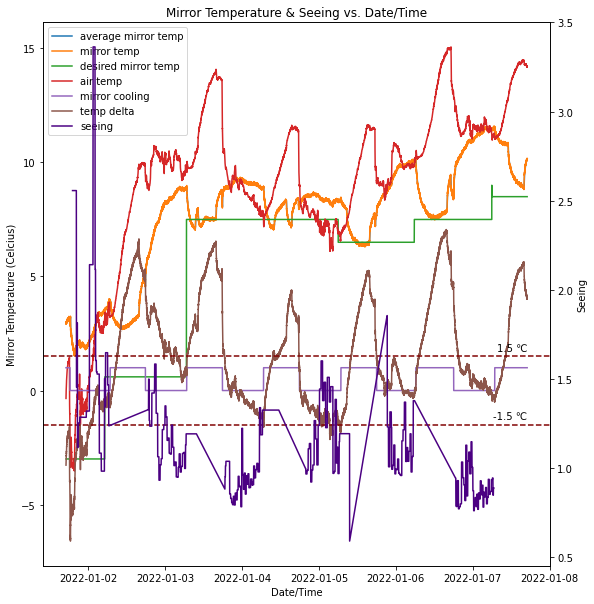

In [145]:
new_temperature_plot(year=2022, month=1, day=15, offset=7, save=True)

Start date: 2022-02-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 7237


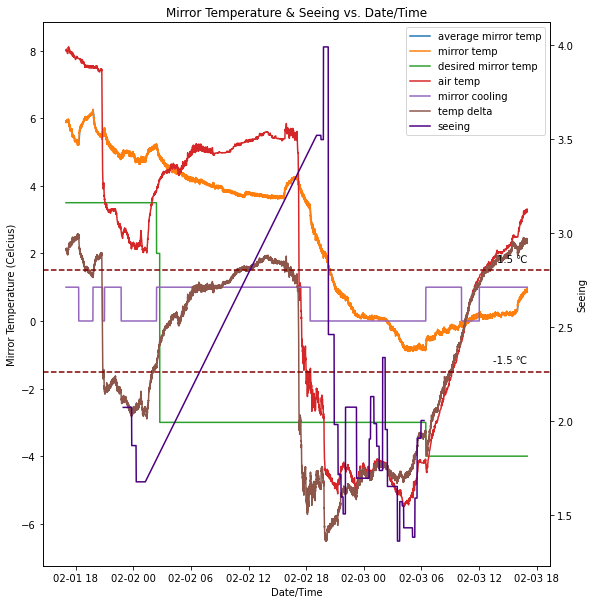

In [146]:
new_temperature_plot(year=2022, month=2, day=1, offset=3, save=True)

Start date: 2022-01-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 12115


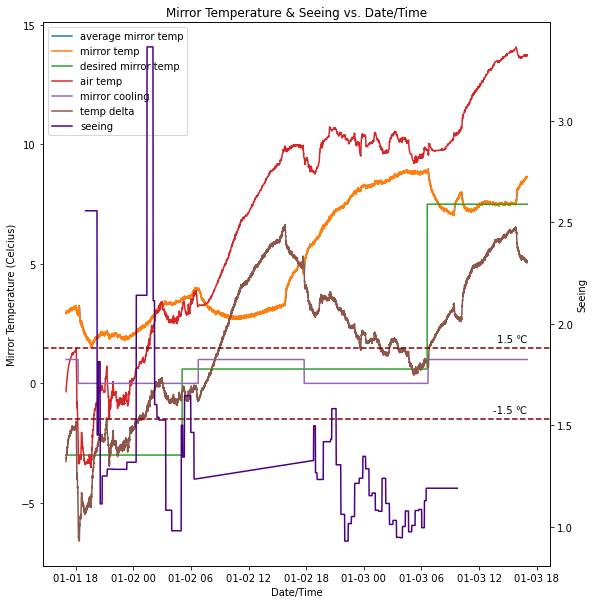

In [147]:
new_temperature_plot(year=2022, month=1, day=15, offset=3, save=True)

Start date: 2022-01-01 17:00:00-07:00
Offset length (# of days): 5
Number of valid telescope environment samples in current time window: 57601
Number of valid etc telemetry samples in current time window: 24574


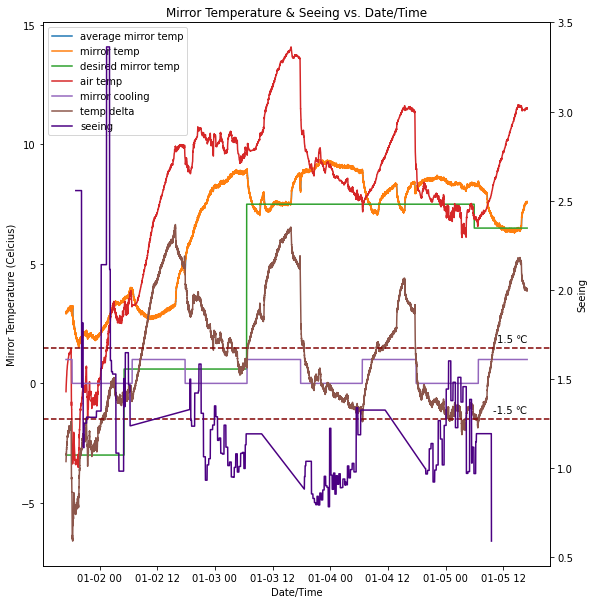

In [148]:
new_temperature_plot(year=2022, month=1, day=15, offset=5, save=True)

Start date: 2022-02-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 7237


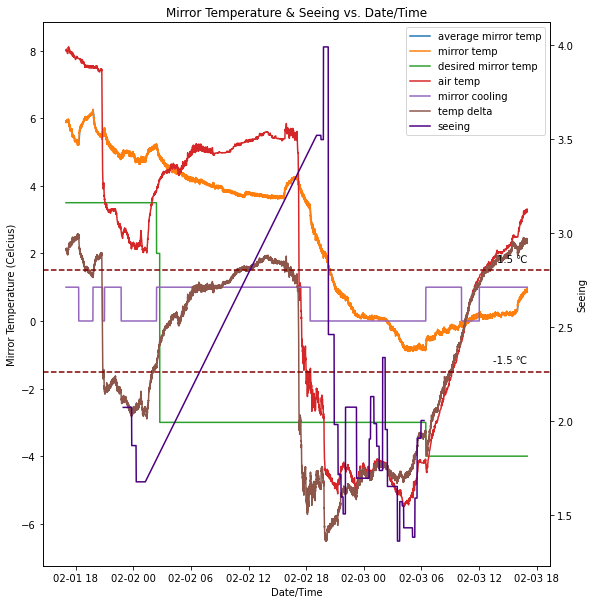

In [149]:
new_temperature_plot(year=2022, month=2, day=15, offset=3, save=True)

Start date: 2022-02-01 17:00:00-07:00
Offset length (# of days): 5
Number of valid telescope environment samples in current time window: 57601
Number of valid etc telemetry samples in current time window: 19703


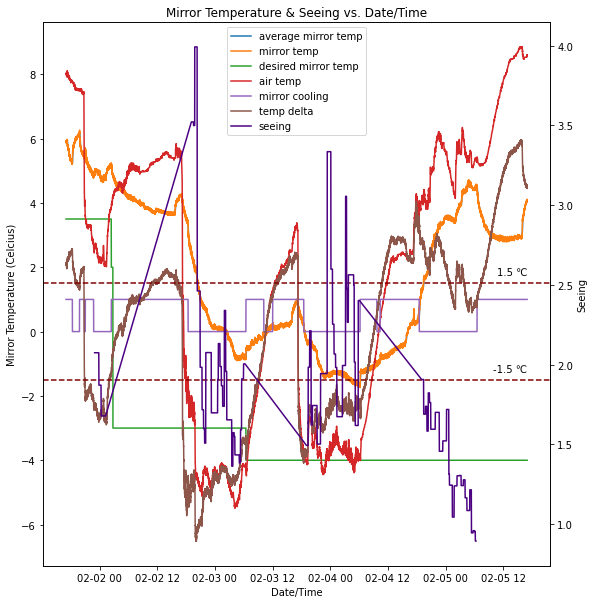

In [150]:
new_temperature_plot(year=2022, month=2, day=15, offset=5, save=True)

Start date: 2022-03-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 8310


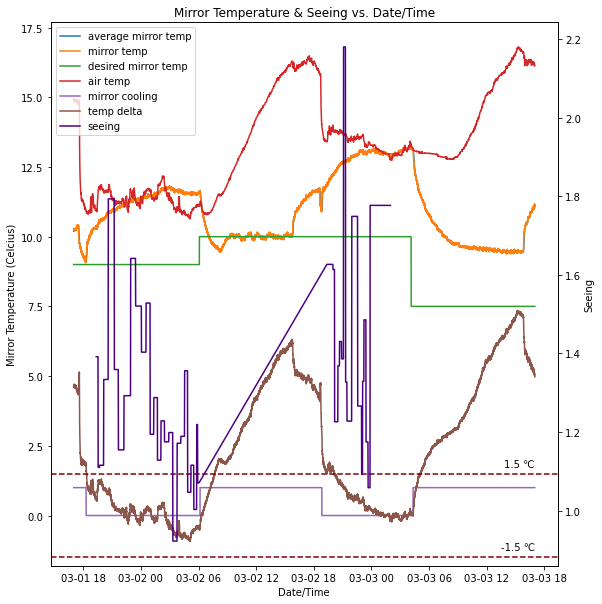

In [151]:
new_temperature_plot(year=2022, month=3, day=15, offset=3, save=True)

Start date: 2022-03-01 17:00:00-07:00
Offset length (# of days): 5
Number of valid telescope environment samples in current time window: 57601
Number of valid etc telemetry samples in current time window: 12085


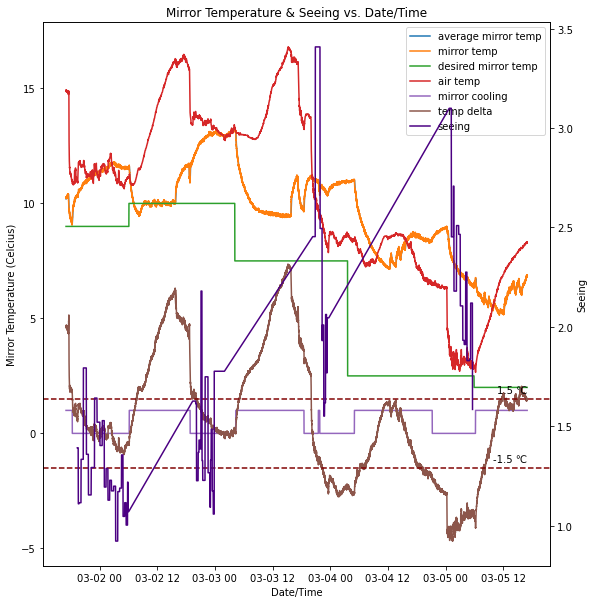

In [152]:
new_temperature_plot(year=2022, month=3, day=15, offset=5, save=True)

Start date: 2022-04-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 10626


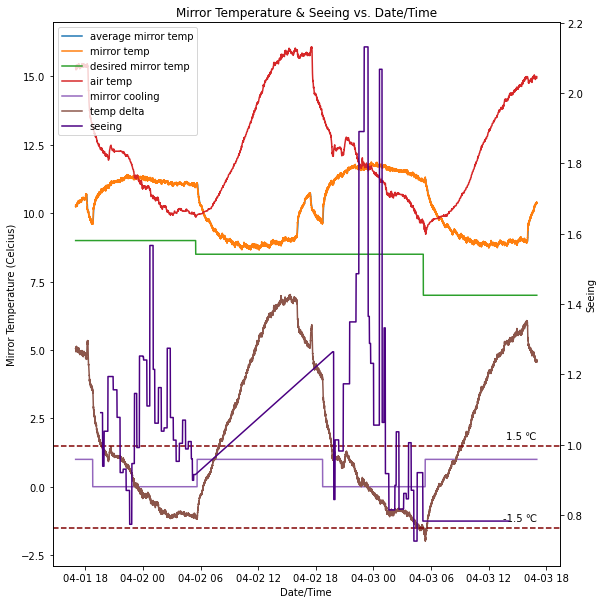

In [153]:
new_temperature_plot(year=2022, month=4, day=15, offset=3, save=True)

Start date: 2022-04-01 17:00:00-07:00
Offset length (# of days): 5
Number of valid telescope environment samples in current time window: 57601
Number of valid etc telemetry samples in current time window: 21319


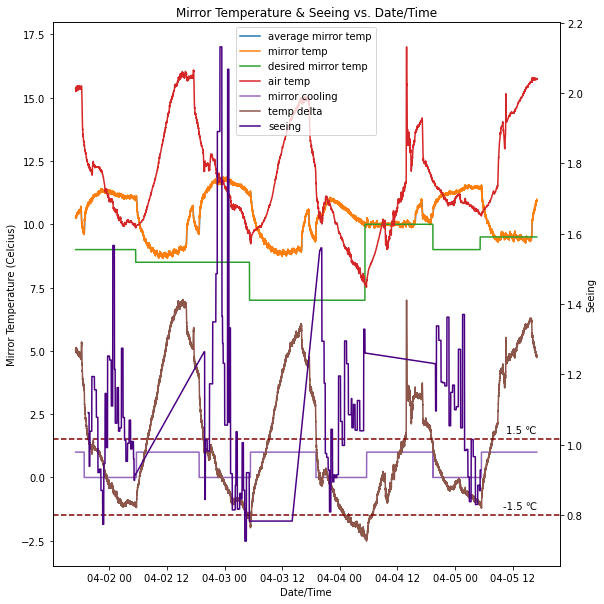

In [154]:
new_temperature_plot(year=2022, month=4, day=15, offset=5, save=True)

Start date: 2022-05-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 3728


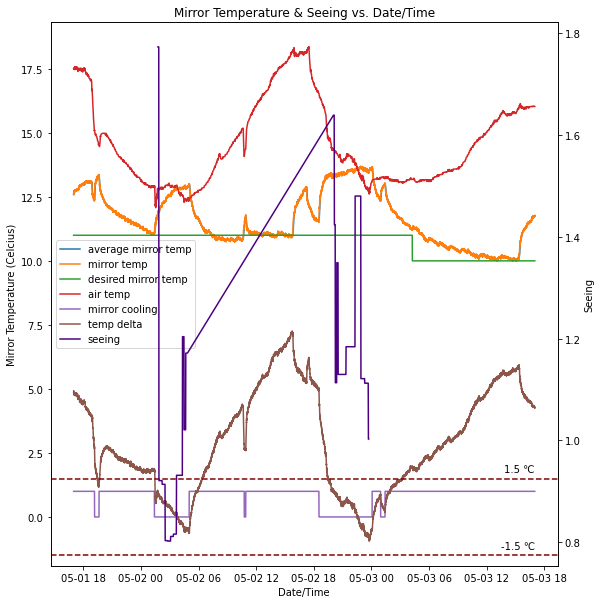

In [155]:
new_temperature_plot(year=2022, month=5, day=15, offset=3, save=True)

Start date: 2022-05-01 17:00:00-07:00
Offset length (# of days): 5
Number of valid telescope environment samples in current time window: 57601
Number of valid etc telemetry samples in current time window: 11697


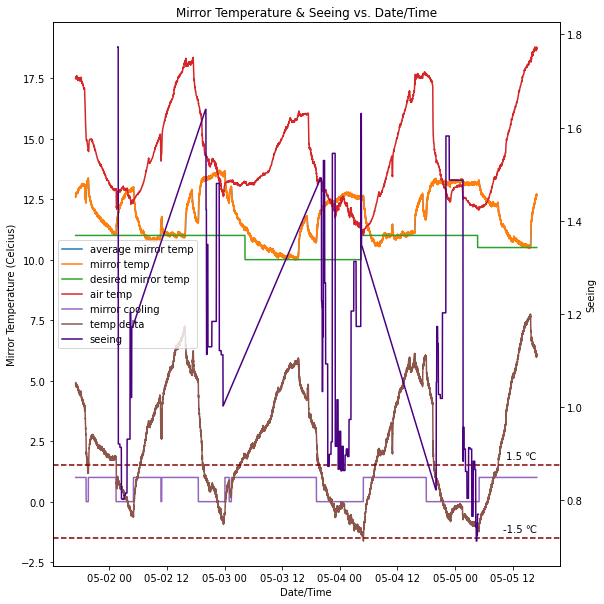

In [156]:
new_temperature_plot(year=2022, month=5, day=15, offset=5, save=True)

Start date: 2022-06-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 9000


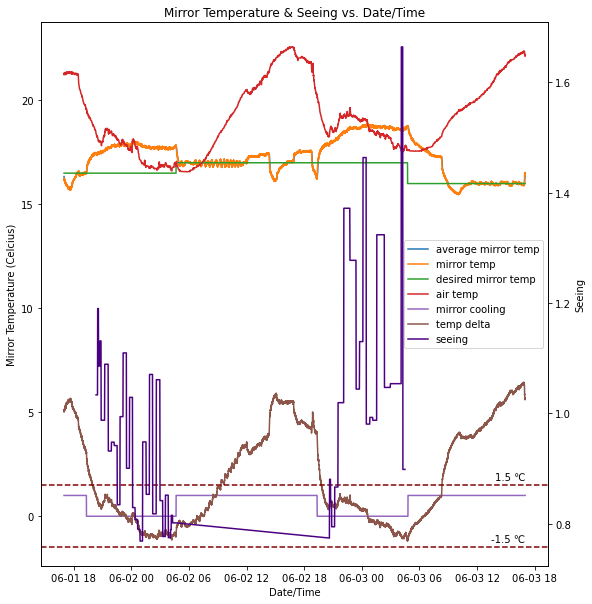

In [157]:
new_temperature_plot(year=2022, month=6, day=15, offset=3, save=True)

Start date: 2022-06-01 17:00:00-07:00
Offset length (# of days): 5
Number of valid telescope environment samples in current time window: 57601
Number of valid etc telemetry samples in current time window: 16177


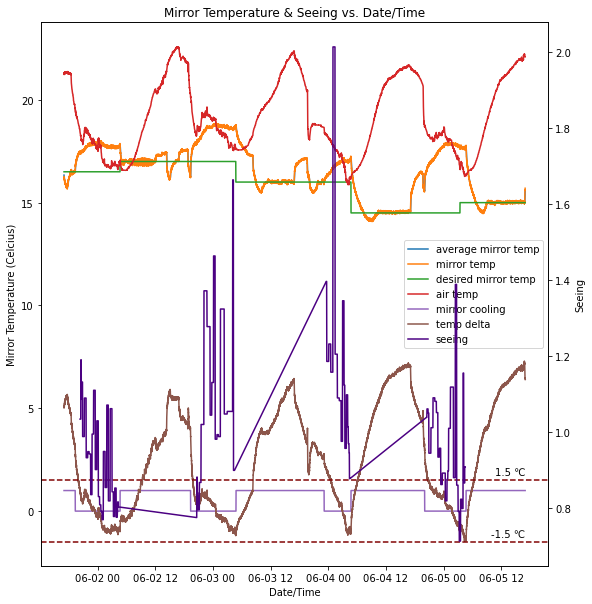

In [158]:
new_temperature_plot(year=2022, month=6, day=15, offset=5, save=True)

Start date: 2022-07-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 0


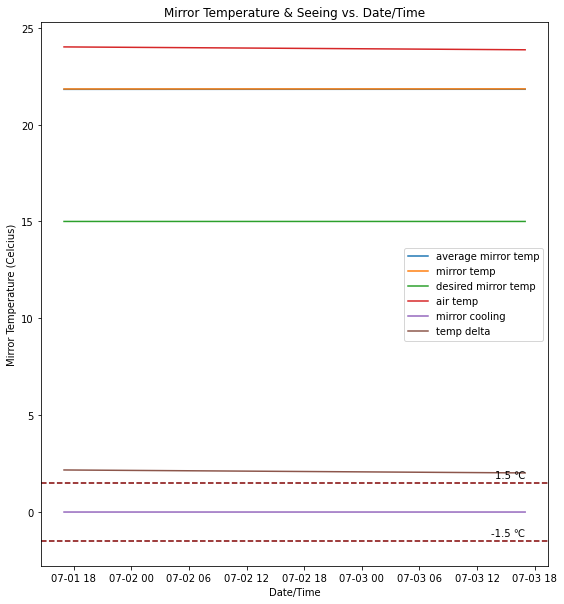

In [159]:
new_temperature_plot(year=2022, month=7, day=15, offset=3, save=True)

Start date: 2022-07-01 17:00:00-07:00
Offset length (# of days): 5
Number of valid telescope environment samples in current time window: 57601
Number of valid etc telemetry samples in current time window: 0


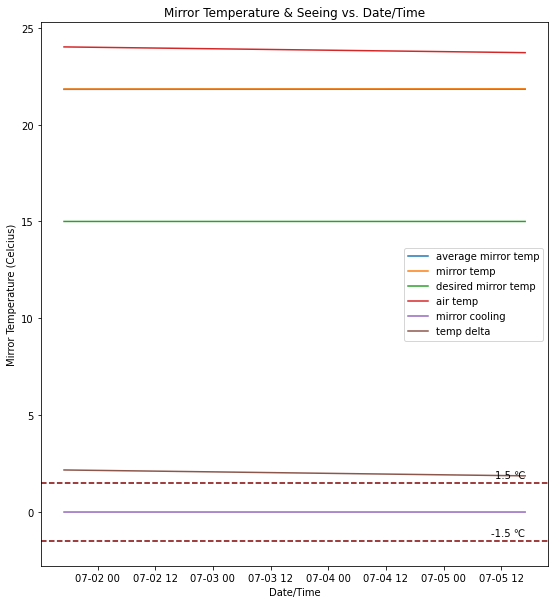

In [160]:
new_temperature_plot(year=2022, month=7, day=15, offset=5, save=True)

Start date: 2022-08-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 0


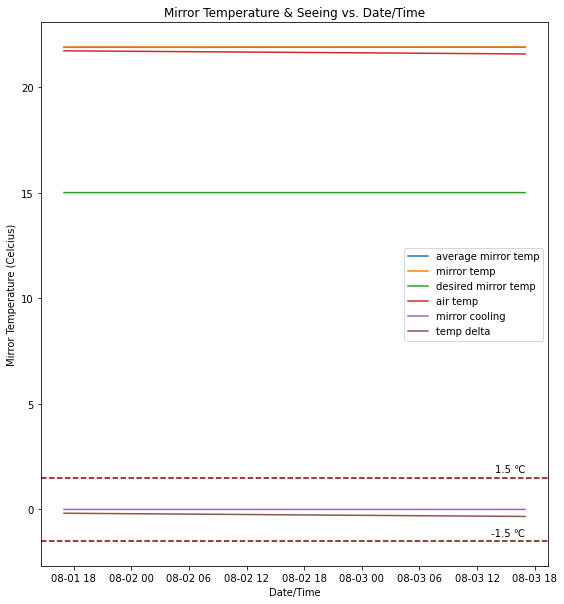

In [161]:
new_temperature_plot(year=2022, month=8, day=15, offset=3, save=True)

Start date: 2022-08-01 17:00:00-07:00
Offset length (# of days): 5
Number of valid telescope environment samples in current time window: 57601
Number of valid etc telemetry samples in current time window: 0


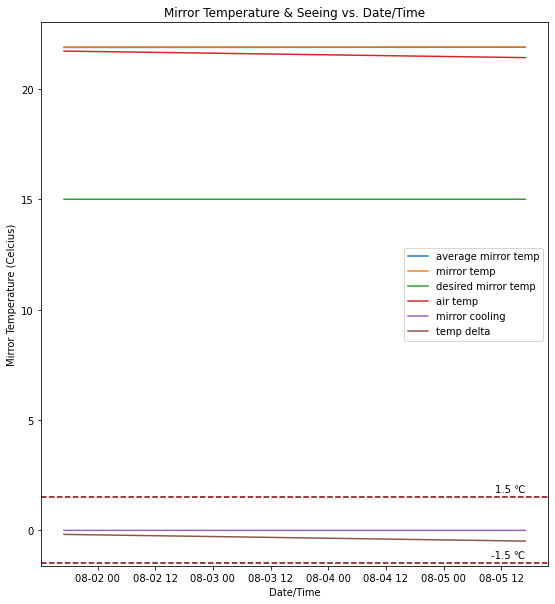

In [162]:
new_temperature_plot(year=2022, month=8, day=15, offset=5, save=True)

Start date: 2022-09-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 0


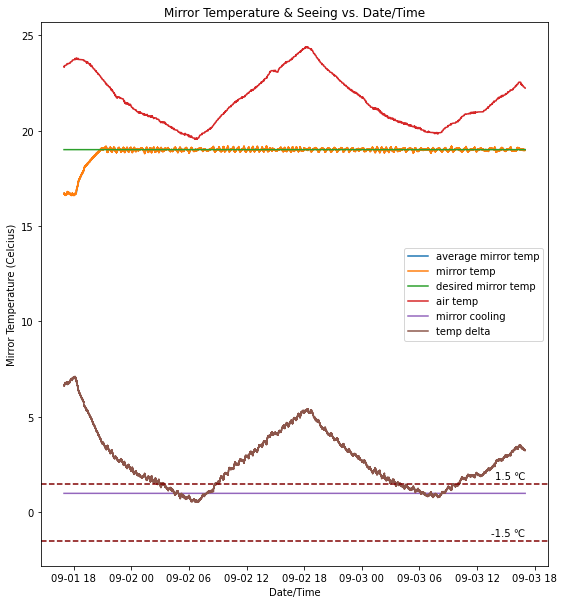

In [163]:
new_temperature_plot(year=2022, month=9, day=15, offset=3, save=True)

Start date: 2022-09-01 17:00:00-07:00
Offset length (# of days): 5
Number of valid telescope environment samples in current time window: 57601
Number of valid etc telemetry samples in current time window: 0


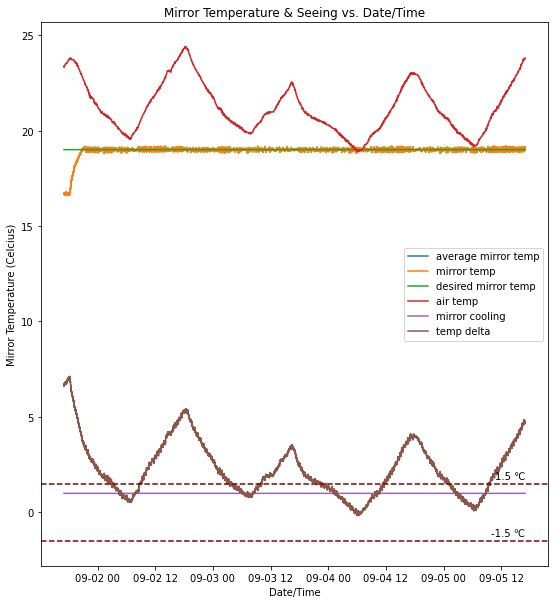

In [164]:
new_temperature_plot(year=2022, month=9, day=15, offset=5, save=True)

Start date: 2022-10-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 9527


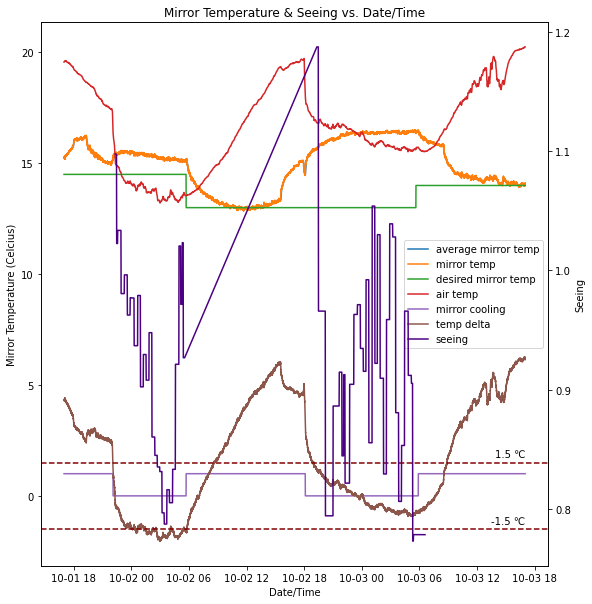

In [165]:
new_temperature_plot(year=2022, month=10, day=15, offset=3, save=True)

Start date: 2022-10-01 17:00:00-07:00
Offset length (# of days): 5
Number of valid telescope environment samples in current time window: 57601
Number of valid etc telemetry samples in current time window: 14285


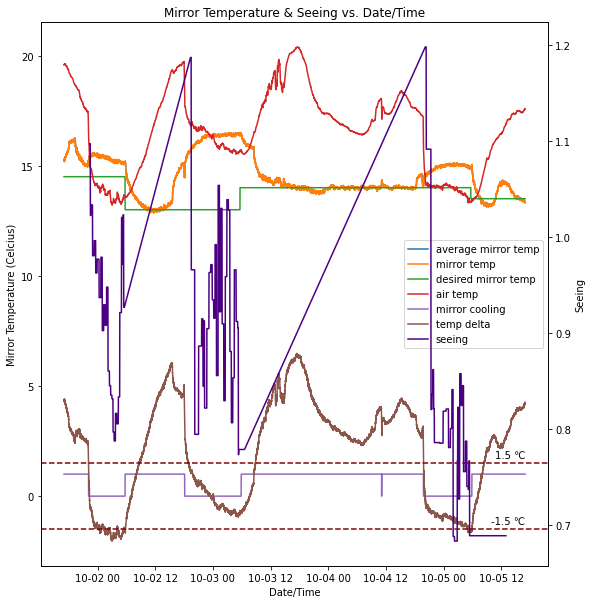

In [166]:
new_temperature_plot(year=2022, month=10, day=15, offset=5, save=True)

Start date: 2022-11-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 3133


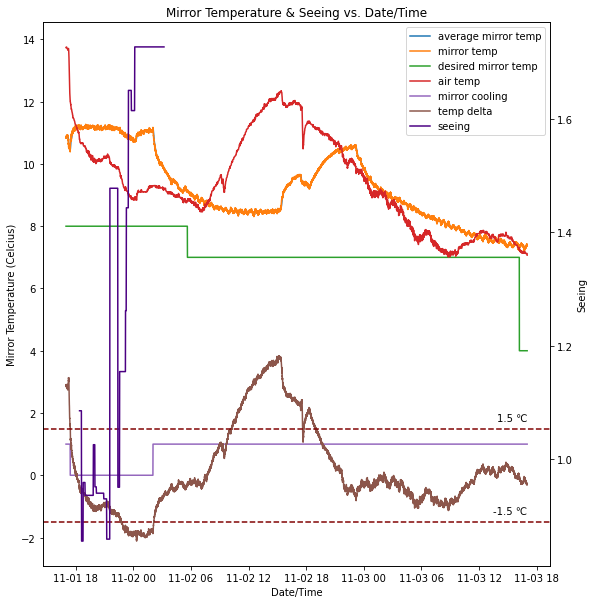

In [167]:
new_temperature_plot(year=2022, month=11, day=15, offset=3, save=True)

Start date: 2022-11-01 17:00:00-07:00
Offset length (# of days): 5
Number of valid telescope environment samples in current time window: 57601
Number of valid etc telemetry samples in current time window: 9115


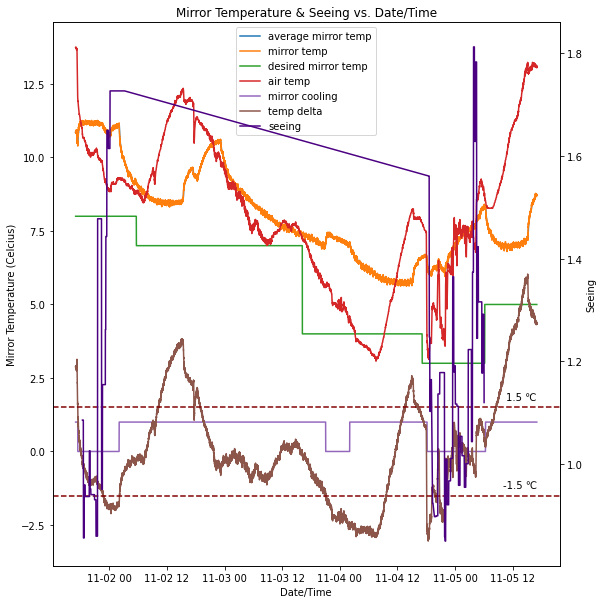

In [168]:
new_temperature_plot(year=2022, month=11, day=15, offset=5, save=True)

Start date: 2022-12-01 17:00:00-07:00
Offset length (# of days): 3
Number of valid telescope environment samples in current time window: 28801
Number of valid etc telemetry samples in current time window: 5494


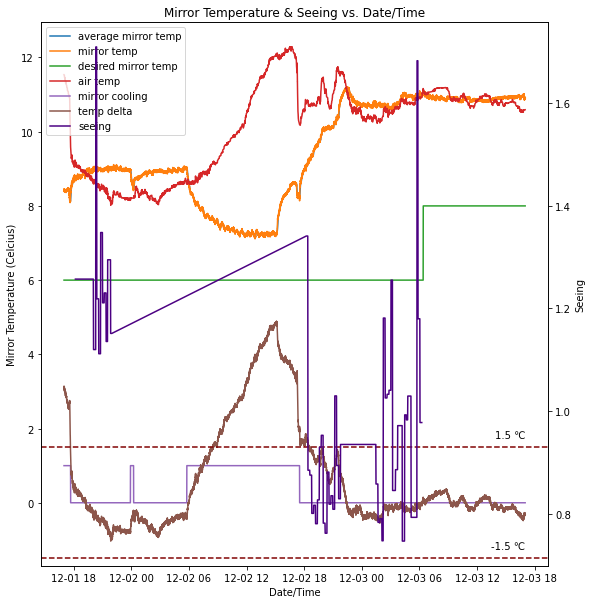

In [169]:
new_temperature_plot(year=2022, month=12, day=15, offset=3, save=True)

Start date: 2022-12-01 17:00:00-07:00
Offset length (# of days): 5
Number of valid telescope environment samples in current time window: 57601
Number of valid etc telemetry samples in current time window: 5494


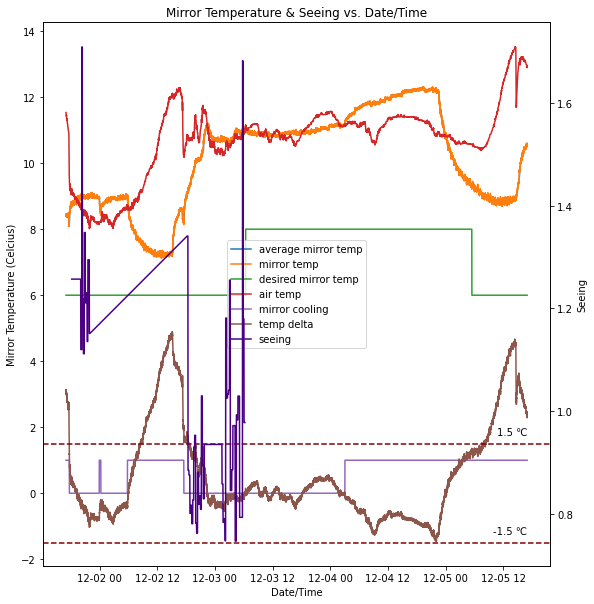

In [170]:
new_temperature_plot(year=2022, month=12, day=15, offset=5, save=True)

In [ ]:
display(Image(filename='correlation/temp_corr_before_sync.png'))

## Unsuccessful sorting and array modification

In [ ]:
# new = temp[temp.index.any() >= start and temp.index.any() <= end]
# print(new)

In [ ]:
# temp = dome_data.copy(deep=True)
# temp.set_index('time_recorded', inplace=True)
# print(type(temp.index))
# temp = temp.resample('6S').mean()
# print(temp)

In [ ]:
# print(min(telescope_data['time_recorded'][start_index+count]))

In [ ]:
# print(telescope_data['time_recorded'].to_pydatetime()) # tried converting array of pandas Timestamp to datetime objects

In [ ]:
# print(telescope_data['time_recorded'][0].to_pydatetime()) # tried converting array of pandas Timestamp to datetime objects

In [ ]:
# print(telescope_data['time_recorded'].apply(lambda x: x.to_pydatetime())) # tried converting array of pandas Timestamp to datetime objects

In [ ]:
# telescope_data['time_recorded'] = telescope_data.assign(time_recored=lambda x: x['time_recorded'].to_pydatetime()) # save time conversion array and display
# print(type(telescope_data['time_recorded'][0]))

In [ ]:
# print(type(sorted_tower_data.sort_values()[0]))

In [ ]:
# print(type(telescope_data['time_recorded'].apply(lambda x: x.to_pydatetime())[0]))

In [ ]:
# assert(tower_data['time_recorded']==tower_data.sort_values(['time_recorded'])['time_recorded'])
# assert(tower_data['time_recorded']==tower_data.sort_values(['time_recorded'])['time_recorded'])

In [ ]:
# print('initial number of samples per table')
# print(f'environmentmonitor_tower: {len(tower_data.index)}')
# print(f'environmentmonitor_dome: {len(dome_data.index)}')
# print(f'environmentmonitor_telescope: {len(telescope_data.index)}')
# print(f'etc_seeing: {len(etc_seeing_data.index)}')
# print(f'etc_telemetry: {len(etc_telemetry_data.index)}')
# print(f'tcs_info: {len(tcs_info_data.index)}')

In [ ]:
# fig, ax = plt.subplots(ncols=4, figsize=(40,10))

# ax[0].scatter(tower_data['time_recorded'], tower_data['temperature'])
# ax[0].set_xlabel('time_recorded')
# ax[0].set_ylabel('temperature')

# ax[1].scatter(telescope_data['time_recorded'], telescope_data['mirror_avg_temp'])
# ax[1].set_xlabel('time_recorded')
# ax[1].set_ylabel('mirror_avg_temp')

# ax[2].scatter(telescope_data['time_recorded'], telescope_data['mirror_desired_temp'])
# ax[2].set_xlabel('time_recorded')
# ax[2].set_ylabel('mirror_desired_temp')

# ax[3].scatter(etc_telemetry['time_recorded'], etc_telemetry['seeing'])
# ax[3].set_xlabel('time_recorded')
# ax[3].set_ylabel('seeing')

# plt.savefig('seeing_vs_time.png')
# plt.show()